<a href="https://colab.research.google.com/github/tomhyhan/noodles/blob/main/pasta_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import userdata
from google.colab import auth

auth.authenticate_user()
token = userdata.get('token')
username = userdata.get('username')
repo_name = "noodles"

In [3]:
import os

!git clone https://github.com/tomhyhan/{repo_name}.git

if os.getcwd() != f"/content/{repo_name}":
    %cd {repo_name}
!git pull
!pwd


fatal: destination path 'noodles' already exists and is not an empty directory.
/content/noodles
From https://github.com/tomhyhan/noodles
   74e6f37..19c3b1d  main       -> origin/main
Already up to date.
/content/noodles


In [4]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "noodles"

GOOGLE_DRIVE_PATH = os.path.join("..", "drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)


In [6]:

from model.utils import test_colab
test_colab()


Hello Colab! from Noodles ha


In [7]:
!pip install torchinfo
!pip install imagehash

In [8]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold


from config.config_manager import ConfigManager
from collections import Counter
from model.data_model import PastaData, create_train_transforms, create_test_transforms
from model.train import trainer, create_model
from model.utils import reset_seed, save_model
from model.data import CLASS_ENCODER, create_csv
from model.viz import class_imbalance, draw_loss, draw_train_val_accuracy

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
config_manager = ConfigManager("./config/config.yml")

SEED = config_manager.config.seed

In [10]:
reset_seed(SEED)

In [11]:
image_path = os.path.join(GOOGLE_DRIVE_PATH, "images")
csv_file_path = os.path.join(GOOGLE_DRIVE_PATH, "pasta_data.csv")

if not os.path.exists(csv_file_path):
    create_csv(image_path, csv_file_path)

In [12]:
data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, "./pasta_data.csv"))
image_paths, labels = data["img_path"], data["label"]

X, test_data, y, test_label = train_test_split(image_paths.values, labels.values, train_size=0.9, random_state=SEED, shuffle=True, stratify=labels)

5033 1258


Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:01<00:00, 195MB/s]


Epoch 1/3:   0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Learning Rate: [9.936476396968407e-05]
Epoch 1 Loss: 2.7358446232477824 Train Accuracy: 0.3294             Validation Accuracy: 0.315
Global gradient norm: 1.9653657841585581


Epoch 2/3:   0%|          | 0/150 [00:00<?, ?it/s]

Learning Rate: [4.57666351956958e-05]
Epoch 2 Loss: 2.456781854629517 Train Accuracy: 0.454             Validation Accuracy: 0.45416666666666666
Global gradient norm: 2.6891297715919045


Epoch 3/3:   0%|          | 0/150 [00:00<?, ?it/s]

Learning Rate: [2.8866422562400154e-09]
Epoch 3 Loss: 2.3469481539726256 Train Accuracy: 0.464             Validation Accuracy: 0.47333333333333333
Global gradient norm: 2.7097200735954896
End of Training for swin Model 4-fold
best accuracy: 0.47333333333333333


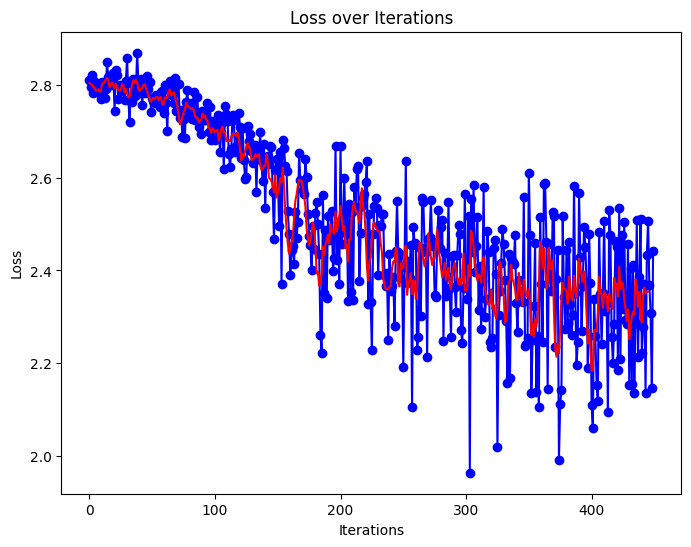

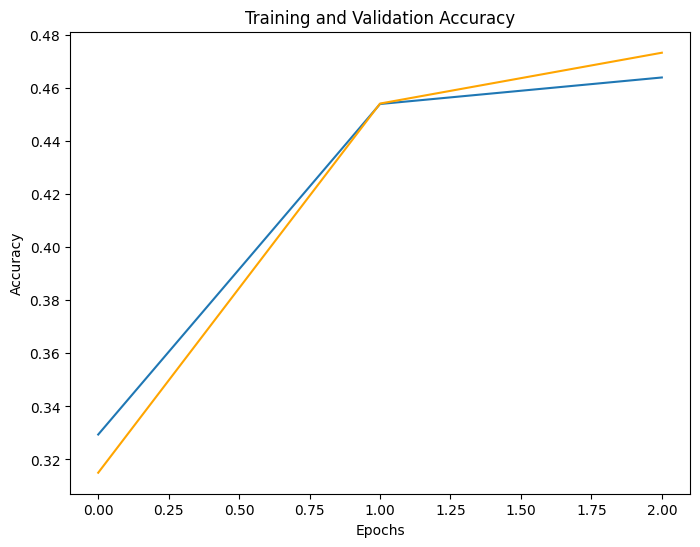

current_model_accuracies [0.47333333333333333]


In [13]:
k_fold = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
models = ['swin' ]

# N=100
# perm_indices = np.random.permutation(N)
# X = X[perm_indices]
# y = y[perm_indices]

for model_name in models:
    current_model_accuracies = []
    for k_id, (train_i, val_i) in enumerate(k_fold.split(X,y)):
        # if k_id in [0,1,2,3]:
        #     continue
        print(len(train_i), len(val_i))
        train_set = X[train_i]
        train_label_set = y[train_i]

        val_set = X[val_i]
        val_label_set = y[val_i]

        model_config = config_manager.config[model_name]
        lr = config_manager.config.lr
        num_epochs = config_manager.config.num_epochs
        num_classes = config_manager.config.num_classes

        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_transform = create_train_transforms()
        test_transform = create_test_transforms()

        train_data = PastaData(train_set, train_label_set, transform_list=train_transform)
        train_data_accuracy = PastaData(train_set, train_label_set, transform_list=test_transform)
        val_data = PastaData(val_set, val_label_set, transform_list=test_transform)

        train_loader = DataLoader(train_data, batch_size=model_config.batch_size, shuffle=False, drop_last=True)
        train_loader_accuracy = DataLoader(train_data_accuracy, batch_size=model_config.batch_size, shuffle=False, drop_last=True)
        val_loader = DataLoader(val_data, batch_size=model_config.batch_size, shuffle=False, drop_last=True)

        model = create_model(model_name, num_classes)
        model.to(device)

        result_dir = os.path.join(GOOGLE_DRIVE_PATH, model_config.output_dir)
        os.makedirs(result_dir, exist_ok=True)

        out_file = os.path.join(result_dir, f"{model_name}_k_fold_{k_id}.pt")

        resume = False
        if os.path.exists(out_file):
            print(f"=== {out_file} exist! ===")
            resume = True

        #  need to make dataframe from images
        loss_history, train_accuracy_history, \
        val_accuracy_history, best_accuracy, model, optimizer, scaler, end_epoch = trainer(
            model,
            train_loader,
            train_loader_accuracy,
            val_loader,
            num_epochs=num_epochs,
            lr=lr,
            model_config=model_config,
            device=device,
            resume=resume,
            out_file=out_file,
            num_classes=num_classes
        )


        current_model_accuracies.append(best_accuracy)
        print(f"End of Training for {model_name} Model {k_id}-fold")
        print(f"best accuracy: {best_accuracy}")

        save_model(model, optimizer, scaler, end_epoch, out_file, best_accuracy)
        # torch.save(best_params, os.path.join(result_dir, f"{model_name}_k_fold_{k_id}.pt"))
        draw_loss(loss_history)
        draw_train_val_accuracy(train_accuracy_history, val_accuracy_history)


    print("current_model_accuracies", current_model_accuracies)


        # avg_accuracy = torch.mean(fold_accuracies)
        # std_accuracy = torch.std(fold_accuracies)

        # general plan
        # 1. save best accuracies
        # 2. compare with different models
        # 3. train on full dataset with best performing model
        # 4. make inference


In [14]:
# Inference

In [15]:
!git pull
!git config --global user.email "tomhyhan@gmail.com"
!git config --global user.name username
!git add .
!git status
!git commit -m "updated trainer"
!git push https://{token}@github.com/{username}/{repo_name}.git

Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date
